In [18]:
""" 
Imatges de sample data > 29 > 15.08.24-16.08.24

"""

' \nImatges de sample data > 29 > 15.08.24-16.08.24\n\n'

In [19]:
"""
pip install torch torchvision torchaudio
pip install detectron2 opencv-python matplotlib numpy
pip install tensorflow tensorflow-datasets
pip install mrcnn

"""

'\npip install torch torchvision torchaudio\npip install detectron2 opencv-python matplotlib numpy\npip install tensorflow tensorflow-datasets\npip install mrcnn\n\n'

In [1]:
import torch
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import json
from torchvision import transforms, models
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon


### Define dataset:

In [4]:
# Define collate_fn
def collate_fn(batch):
    return tuple(zip(*batch))

class BabySegmentationDataset(Dataset):
    def __init__(self, image_folder, annotation_file, transforms=None):
        """
        Args:
            image_folder (str): Path to the folder with images.
            annotation_file (str): Path to the annotations.json file.
            transforms (callable, optional): Optional transform to be applied on an image.
        """
        self.image_folder = image_folder
        self.transforms = transforms
        
        # Load annotations from COCO-style JSON file
        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)
        
        self.image_info = {img['id']: img for img in self.coco_data['images']}
        self.annotations = self.coco_data['annotations']
        
        # Filter annotations based on your object of interest (e.g., 'baby')
        self.baby_annotations = [anno for anno in self.annotations if anno['category_id'] == 1]

    def __len__(self):
        return len(self.baby_annotations)

    def __getitem__(self, idx):
        annotation = self.baby_annotations[idx]
        img_id = annotation['image_id']
        img_info = self.image_info[img_id]
        
        # Get image file path
        img_name = img_info['file_name']
        

        img_path = os.path.join(self.image_folder, img_name.replace("\\", "/"))
        
        #remove one "JPEGImages/" from the path, only once since it appears twice
        img_path = img_path.replace("JPEGImages/", "", 1)

        image = Image.open(img_path).convert("RGB")
        
        # Get mask and bounding box from annotation
        mask = np.zeros((image.height, image.width), dtype=np.uint8)
        segmentation = annotation['segmentation']
        
        # Handle polyline or polygon segmentation
        if isinstance(segmentation, list):  # If polygon format
            for poly in segmentation:
                mask = self.polygons_to_mask(poly, mask)
        
        # Get bounding box
        xmin, ymin, xmax, ymax = annotation['bbox']
        
        # Prepare target dictionary
        target = {}
        target['boxes'] = torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32)
        target['labels'] = torch.tensor([1], dtype=torch.int64)  # Label for 'baby'
        target['masks'] = torch.tensor(mask, dtype=torch.uint8).unsqueeze(0)  # Add channel dimension

        if self.transforms:
            image = self.transforms(image)

        return image, target

    def polygons_to_mask(self, polygon, mask):
        """
        Converts a polygon segmentation into a mask.
        """
        # This assumes that the polygon is a list of points.
        # Use your preferred method to convert polygons to masks (e.g., rasterization)
        from shapely.geometry import Polygon
        
        polygon = Polygon(np.array(polygon).reshape((-1, 2)))
        for y in range(mask.shape[0]):
            for x in range(mask.shape[1]):
                if polygon.contains(Point(x, y)):
                    mask[y, x] = 1
        return mask

image_folder = '/home/martina/codi2/3year/synthesisII/prova_dataset/coco_annotations/JPEGImages'
annotation_file = '/home/martina/codi2/3year/synthesisII/prova_dataset/coco_annotations/annotations.json'

# Transformations
transform = transforms.Compose([
    transforms.Resize((800, 800)),
    transforms.ToTensor(),
])

# Load the dataset
dataset = BabySegmentationDataset(
    image_folder=image_folder,
    annotation_file=annotation_file,
    transforms=transform
)


from torch.utils.data import random_split

# Define split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].


Prova nomes per veure que tenim be les masks


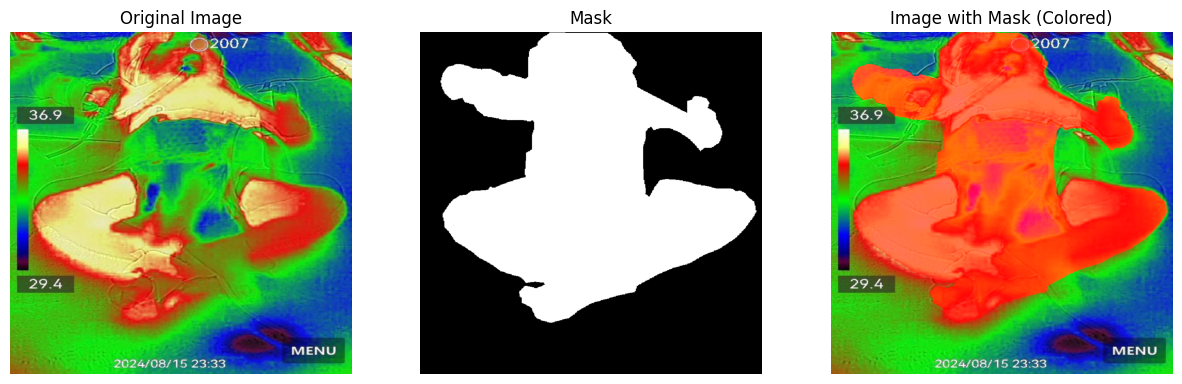

In [5]:
# Assuming you have already loaded the dataset and transformed it
image, target = train_dataset[0]

# Convert the image from a tensor back to a numpy array for plotting
image_np = image.permute(1, 2, 0).numpy()

# Get the mask from the target (assuming it's a single channel mask)
mask = target['masks'].numpy()[0]  # Shape: (H, W)

# Resize mask to match image size (if necessary)
mask_resized = Image.fromarray(mask.astype(np.uint8)).resize((image_np.shape[1], image_np.shape[0]), Image.NEAREST)
mask_resized = np.array(mask_resized)

# Create a colored mask (e.g., red)
colored_mask = np.zeros_like(image_np)
colored_mask[mask_resized == 1] = [255, 0, 0]  # Red color for the "baby" area

# Combine the original image with the colored mask
image_with_mask = np.copy(image_np)
image_with_mask[mask_resized == 1] = 0.5 * image_with_mask[mask_resized == 1] + 0.5 * colored_mask[mask_resized == 1]  # Blend the colors

# Plotting the images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot original image
ax[0].imshow(image_np)
ax[0].set_title("Original Image")
ax[0].axis('off')

# Plot mask
ax[1].imshow(mask_resized, cmap='gray')
ax[1].set_title("Mask")
ax[1].axis('off')

# Plot image with the solid color mask
ax[2].imshow(image_with_mask)
ax[2].set_title("Image with Mask (Colored)")
ax[2].axis('off')
print("Prova nomes per veure que tenim be les masks")
plt.show()

In [6]:
import torch
from torchvision import models
from torch.utils.data import DataLoader
from torch.optim import Adam

# Load pre-trained Mask R-CNN model
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # 1 for baby + 1 for background

# Modify classifier and mask predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, 256, num_classes)

# Freeze backbone layers (optional)
for param in model.backbone.parameters():
    param.requires_grad = False

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = Adam(model.parameters(), lr=0.0001)

# Training Loop
num_epochs = 5  # Start with 5 epochs; increase if needed
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for images, targets in train_loader:
        # Move images and targets to device
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        total_loss = sum(loss for loss in loss_dict.values())

        # Backpropagation
        total_loss.backward()
        optimizer.step()
        
        train_loss += total_loss.item()
        print(f"Batch Loss: {total_loss.item()}")

    # Print epoch loss
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss / len(train_loader)}")

# Save the trained model
torch.save(model.state_dict(), "model.pth")
print("Model saved successfully!")


/home/martina/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/martina/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Batch Loss: 3.052791118621826
Batch Loss: 1.4677568674087524
Batch Loss: 1.1783782243728638
Batch Loss: 1.264433741569519
Batch Loss: 1.2586346864700317
Epoch 1/5 - Training Loss: 1.6443989276885986
Batch Loss: 0.8226419687271118
Batch Loss: 0.7632749080657959
Batch Loss: 0.8209857940673828
Batch Loss: 0.8159220814704895
Batch Loss: 0.6446099281311035
Epoch 2/5 - Training Loss: 0.7734869360923767
Batch Loss: 0.7002045512199402
Batch Loss: 0.7468355894088745
Batch Loss: 0.5832032561302185
Batch Loss: 0.539456844329834
Batch Loss: 0.592544436454773
Epoch 3/5 - Training Loss: 0.632448935508728
Batch Loss: 0.559079647064209
Batch Loss: 0.5559350252151489
Batch Loss: 0.4475519061088562
Batch Loss: 0.4518420398235321
Batch Loss: 0.6940669417381287
Epoch 4/5 - Training Loss: 0.541695111989975
Batch Loss: 0.4158869981765747
Batch Loss: 0.3545302152633667
Batch Loss: 0.5299792885780334
Batch Loss: 0.626600444316864
Batch Loss: 0.4027452766895294
Epoch 5/5 - Training Loss: 0.46594844460487367
Mo

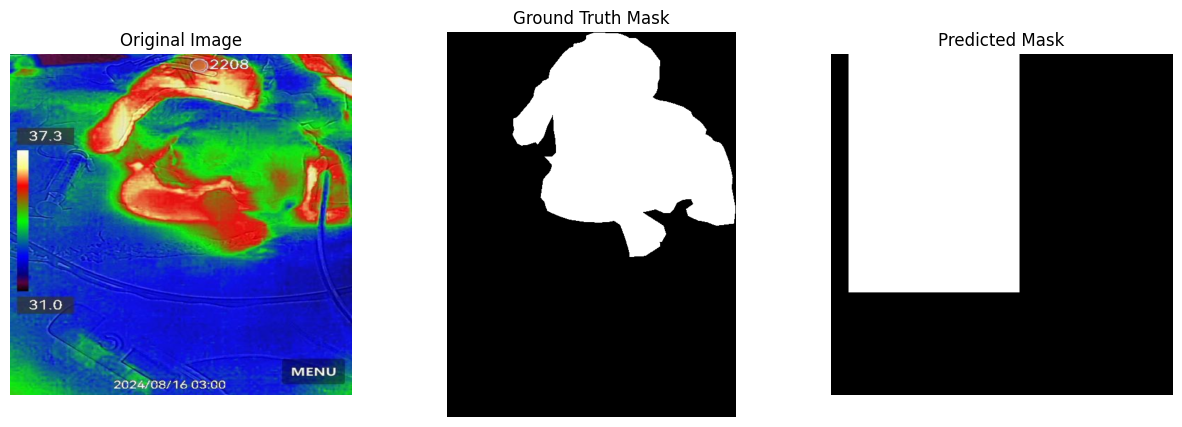

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Ensure model is in evaluation mode
model.eval()

# Get a batch from validation loader
for images, targets in val_loader:  
    with torch.no_grad():
        # Move to device (if using GPU)
        images = [img.to(device) for img in images]

        # Get predictions
        outputs = model(images)

    # Extract the first image, ground truth mask, and predicted mask
    gt_mask = targets[0]['masks'][0].cpu().numpy()  # Convert to numpy
    if gt_mask.ndim == 3:  # If shape is (1, H, W), remove the extra dimension
        gt_mask = gt_mask.squeeze(0)

    pred_mask = outputs[0]['masks'][0].cpu().sigmoid().numpy()
    if pred_mask.ndim == 3:  # If shape is (1, H, W), remove the extra dimension
        pred_mask = pred_mask.squeeze(0)

    # Threshold the predicted mask
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Plot original image, ground truth mask, and predicted mask
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(gt_mask, cmap='gray')
    ax[1].set_title("Ground Truth Mask")
    ax[1].axis('off')

    ax[2].imshow(pred_mask, cmap='gray')
    ax[2].set_title("Predicted Mask")
    ax[2].axis('off')

    plt.show()
    break